In [1]:
from numpy import *
from numpy.random import rand, randn, randint
from dPCA import dPCA
import matplotlib.pyplot as plt

We first build surrogate data to apply dPCA to.

In [2]:
# number of neurons, time-points and stimuli
N,T,S = 100,250,6

# noise-level and number of trials in each condition
noise, n_samples = 0.2, 10

# build two latent factors
zt = (arange(T)/float(T))
zs = (arange(S)/float(S))

# build trial-by trial data
trialR = noise*randn(n_samples,N,S,T)
trialR += randn(N)[None,:,None,None]*zt[None,None,None,:]
trialR += randn(N)[None,:,None,None]*zs[None,None,:,None]

# trial-average data
R = mean(trialR,0)

# center data
R -= mean(R.reshape((N,-1)),1)[:,None,None]

We then instantiate a dPCA model where the two parameter axis are labeled by 's' (stimulus) and 't' (time) respectively. We set regularizer to 'auto' to optimize the regularization parameter when we fit the data.

In [3]:
dpca = dPCA.dPCA(labels='st',regularizer='auto')
dpca.protect = ['t']

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


Now fit the data (R) using the model we just instatiated. Note that we only need trial-to-trial data when we want to optimize over the regularization parameter.

In [10]:
print('R shape:', R.shape)
print('trialR shape:', trialR.shape)

R shape: (100, 6, 250)
trialR shape: (10, 100, 6, 250)


In [4]:
Z = dpca.fit_transform(R,trialR)

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.000449987958058483
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [5]:
dpca._marginalize(trialR)

OrderedDict([('s',
              array([[-0.10404952, -0.1668806 , -0.07418012, ...,  0.07306361,
                       0.08658141,  0.31542706],
                     [ 0.01525072,  0.04231579,  0.02041391, ...,  0.07475126,
                       0.16977698,  0.12722027],
                     [ 0.03581949, -0.02087038, -0.06740377, ...,  0.27090566,
                       0.18731327,  0.17218337],
                     ...,
                     [ 0.09070008,  0.00477803, -0.0789884 , ...,  0.13245428,
                       0.03820415,  0.10077217],
                     [-0.1066327 , -0.03664093, -0.04824903, ...,  0.18790927,
                      -0.00372847,  0.12185619],
                     [ 0.02449325, -0.0673825 ,  0.00733445, ...,  0.18544299,
                       0.20383967,  0.21419048]])),
             ('t',
              array([[ 0.01436376,  0.00792505,  0.02589231, ..., -0.00321833,
                      -0.01815969, -0.02333935],
                     [ 0.01569105,  0

In [6]:
dpca.explained_variance_ratio_

{'s': [np.float64(0.5470103179937176),
  np.float64(3.34552250558284e-09),
  np.float64(2.668007567861276e-09),
  np.float64(2.271358553866043e-09),
  np.float64(1.1988336135396016e-09),
  np.float64(1.0134189903962398e-31),
  np.float64(1.0458671736042146e-32),
  np.float64(3.332528348181583e-32),
  np.float64(5.034759693209824e-32),
  np.float64(5.827615504408779e-32)],
 't': [np.float64(0.40820042611188034),
  np.float64(1.0053906400241181e-07),
  np.float64(1.0262246944454332e-07),
  np.float64(9.488383388971786e-08),
  np.float64(8.79876807762214e-08),
  np.float64(8.934011761105103e-08),
  np.float64(7.395179284294149e-08),
  np.float64(6.092293291605736e-08),
  np.float64(6.508509288040908e-08),
  np.float64(6.043935976905615e-08)],
 'st': [np.float64(1.2254840813990755e-06),
  np.float64(1.1523309443118318e-06),
  np.float64(9.78932088124225e-07),
  np.float64(9.76946750291177e-07),
  np.float64(9.212648775265346e-07),
  np.float64(8.041234009906926e-07),
  np.float64(8.2553419

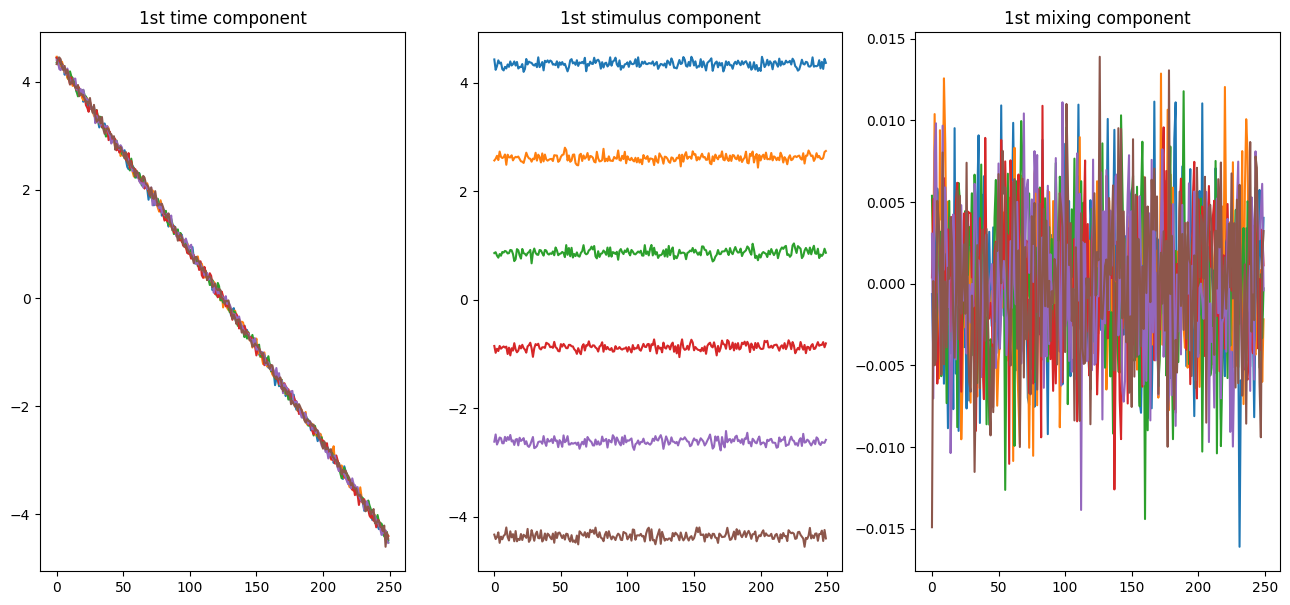

In [7]:
time = arange(T)

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(S):
    plt.plot(time,Z['t'][0,s])

plt.title('1st time component')
    
plt.subplot(132)

for s in range(S):
    plt.plot(time,Z['s'][0,s])
    
plt.title('1st stimulus component')
    
plt.subplot(133)

for s in range(S):
    plt.plot(time,Z['st'][0,s])
    
plt.title('1st mixing component')
plt.show()

The 1st mixing component looks merely like noise. But to be sure, we can run a significance analysis:

In [8]:
significance_masks = dpca.significance_analysis(R,  trialR, n_shuffles=10, n_splits=10, n_consecutive=10)

Compute score of data:  . . . . . . . . . . Finished.
Compute score of shuffled data:  9 / 10 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

We can highlight the significant parts of the demixed components with a black bar underneath. Note that there is no significant analysis time, since there are no classes to compute the significance over.

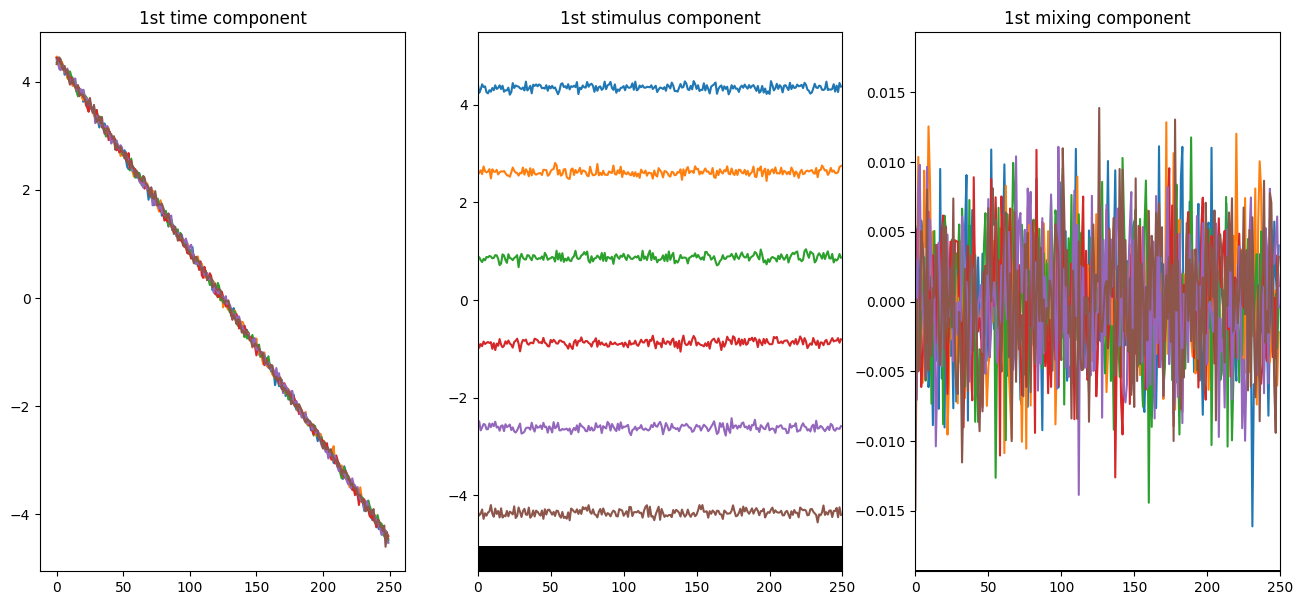

In [9]:
time = arange(T)

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(S):
    plt.plot(time,Z['t'][0,s])

plt.title('1st time component')
    
plt.subplot(132)

for s in range(S):
    plt.plot(time,Z['s'][0,s])

plt.imshow(significance_masks['s'][0][None,:],extent=[0,250,amin(Z['s'])-1,amin(Z['s'])-0.5],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
plt.ylim([amin(Z['s'])-1,amax(Z['s'])+1])

plt.title('1st stimulus component')
    
plt.subplot(133)

for s in range(S):
    plt.plot(time,Z['st'][0,s])

dZ = amax(Z['st'])-amin(Z['st'])
plt.imshow(significance_masks['st'][0][None,:],extent=[0,250,amin(Z['st'])-dZ/10.,amin(Z['st'])-dZ/5.],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
plt.ylim([amin(Z['st'])-dZ/10.,amax(Z['st'])+dZ/10.])
    
plt.title('1st mixing component')
plt.show()

Now we try the code on the Romo dataset

In [10]:
# Data loading and manipulation
import pandas as pd
from pymatreader import read_mat

In [11]:
Path = '/Users/pica/Documents/Ildefonso PhD/Christian (PCA)/Data/romo_allpsth.mat'
X = read_mat(Path)['X']

In [12]:
# Shorten data (optional)
X = X[:,:,2251:4750]

In [13]:
N,S,T = X.shape

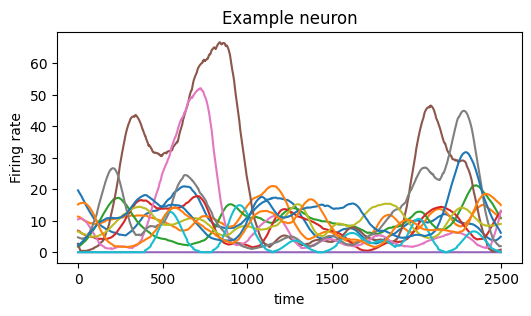

In [14]:
plt.figure(figsize=(6,3))
plt.plot(X[0,:,:].T)
plt.xlabel('time')
plt.ylabel('Firing rate')
plt.title('Example neuron')
plt.show()

In [ ]:
dpca = dPCA.dPCA(labels='st', join={'s': ['s', 'st']}, n_components=20, regularizer=0.000001)
dpca.protect = ['t']

In [16]:
Z = dpca.fit_transform(X)

In [17]:
print(f'Category-independent: {100*sum(dpca.explained_variance_ratio_["t"]):.1f}%')
print(f'Stimulus-dependent: {100*sum(dpca.explained_variance_ratio_["s"]):.1f}%')

Category-independent: 74.3%
Stimulus-dependent: 13.5%


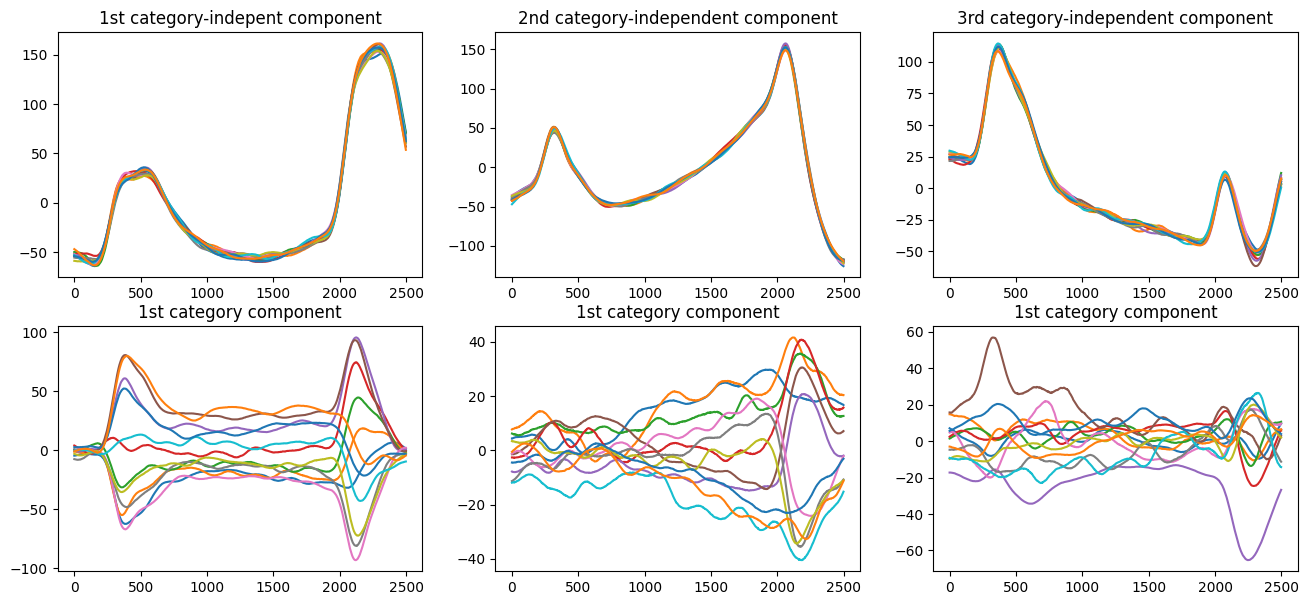

In [18]:
time = arange(T)

plt.figure(figsize=(16,7))
plt.subplot(231)

for s in range(S):
    plt.plot(time,Z['t'][0,s])

plt.title('1st category-indepent component')

plt.subplot(232)

for s in range(S):
    plt.plot(time,Z['t'][1,s])

plt.title('2nd category-independent component')

plt.subplot(233)

for s in range(S):
    plt.plot(time,Z['t'][2,s])
    
plt.title('3rd category-independent component')

plt.subplot(234)

for s in range(S):
    plt.plot(time,Z['s'][0,s])
    
plt.title('1st category component')
    
plt.subplot(235)

for s in range(S):
    plt.plot(time,Z['s'][1,s])
    
plt.title('1st category component')

plt.subplot(236)

for s in range(S):
    plt.plot(time,Z['s'][2,s])
    
plt.title('1st category component')
plt.show()